In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_18/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_18.csv').dropna().reset_index(drop=True)
print(training_data_df.shape)
training_data_df.head()

(345087, 252)
Wall time: 3.46 s


,지번주소,건물연식,금액(만원),가격대지권면적,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,xy,공시지가(만원),표준지여부,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가·착공제한지역,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공원,공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타보건위생시설,기타수도시설,기타자동차정류장,기타주차장시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),보전산지,보전임지,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,열공급설비,온천공보호구역,완충녹지,용도구역기타,원추표면구역,원형보존지,유수지,유원지,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지하도로,진입표면구역,집단취락지구,철도,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,폐기물처리시설,하수도,하천,하천구역,학교,학교시설보호지구,학교환경위생_정화구역,현상변경허가_대상구역
0,서울특별시 강남구 대치동 894-0,30,300000.0,1857.585139,1.583333,-0.500000,-0.866025,6030.985219,-6274.443335,1.818639e+07,1.968432e+07,-3.784108e+07,1121.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,서울특별시 강남구 대치동 894-0,31,300000.0,1857.585139,2.166667,0.866025,0.500000,6030.985219,-6274.443335,1.818639e+07,1.968432e+07,-3.784108e+07,1183.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,서울특별시 강남구 대치동 894-0,31,300000.0,1857.585139,2.166667,0.866025,0.500000,6030.985219,-6274.443335,1.818639e+07,1.968432e+07,-3.784108e+07,1183.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,서울특별시 강남구 대치동 894-0,31,300000.0,1857.585139

# Training

In [3]:
from sklearn.model_selection import KFold, GroupKFold

In [4]:
import lightgbm as lgb

In [5]:
from sklearn.metrics import r2_score

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

In [12]:
target_cols = ['금액(만원)', '가격대지권면적', '지번주소']

In [13]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df

,colname
0,표준지여부
1,지목명
2,용도지역명1
3,용도지역명2
4,토지이동상황
5,지형높이
6,지형형상
7,도로접면
8,(한강)폐기물매립시설_설치제한지역
9,4대문안


In [14]:
cat_cols = cat_cols_df['colname'].tolist()
cat_cols

['표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면',
 '(한강)폐기물매립시설_설치제한지역',
 '4대문안',
 '가로구역별_최고높이_제한지역',
 '가스공급설비',
 '가축사육제한구역',
 '개발제한구역',
 '개발행위허가제한지역',
 '건축선',
 '건축용도지역기타',
 '건축용도지역미분류',
 '건축허가·착공제한지역',
 '경관녹지',
 '경관지구',
 '경관지구기타',
 '고도지구',
 '고등학교',
 '고속철도',
 '공공공지',
 '공공시설구역',
 '공공주택지구',
 '공공지원민간임대주택_공급촉진지구',
 '공공청사',
 '공원',
 '공원자연보존지구',
 '공원자연환경지구',
 '공익용산지',
 '공익임지',
 '공장설립승인지역',
 '공장설립제한지역',
 '공항소음피해예상지역',
 '공항시설보호지구',
 '과밀억제권역',
 '광로1류(폭_70M_이상)',
 '광로2류(폭_50M~70M)',
 '광로3류(폭_40M~50M)',
 '광장',
 '교육환경보호구역',
 '교통광장',
 '국가산업단지',
 '국가지정문화재구역',
 '국가하천',
 '국립공원',
 '국민임대주택단지예정지구',
 '국지도로',
 '국토이용용도지구기타',
 '근린공원',
 '근린광장',
 '근린상업지역',
 '기타공공공지시설',
 '기타공공청사시설',
 '기타공원시설',
 '기타교통시설',
 '기타녹지시설',
 '기타도로시설',
 '기타도시공간시설',
 '기타보건위생시설',
 '기타수도시설',
 '기타자동차정류장',
 '기타주차장시설',
 '기타폐기물처리시설',
 '노외주차장',
 '녹지',
 '대공방어협조구역',
 '대공방어협조구역(위탁고도54-236m)',
 '대공방어협조구역(위탁고도77-257m)',
 '대로1류(폭_35M~40M)',
 '대로2류(폭_30M~35M)',
 '대로3류(폭_25M~30M)',
 '대학',
 '도로',
 '도로구역',
 '도서관',
 '도시개발구역',
 '도

Fold 0 start
(276069, 249)
y dist plot


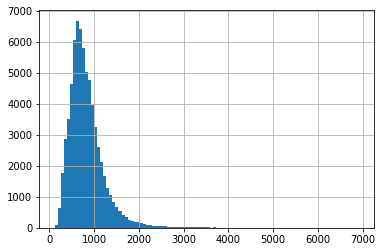

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2401
[LightGBM] [Info] Number of data points in the train set: 276069, number of used features: 210
[LightGBM] [Info] Start training from score 828.062364
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 213.522
[100]	valid_0's rmse: 201.435
[150]	valid_0's rmse: 195.863
[200]	valid_0's rmse: 191.914
[250]	valid_0's rmse: 188.971
[300]	valid_0's rmse: 186.598
[350]	valid_0's rmse: 184.614
[400]	valid_0's rmse: 183.041
[450]	valid_0's rmse: 181.427
[500]	valid_0's rmse: 180.118
[550]	valid_0's rmse: 178.814
[600]	valid_0's rmse: 177.56
[650]	valid_0's rmse: 176.645
[700]	valid_0's rmse: 175.787
[750]	valid_0's rmse: 174.972
[800]	valid_0's rmse: 174.27
[850]	valid_0's rmse: 173.602
[900]	valid_0's rm

<Figure size 432x288 with 0 Axes>

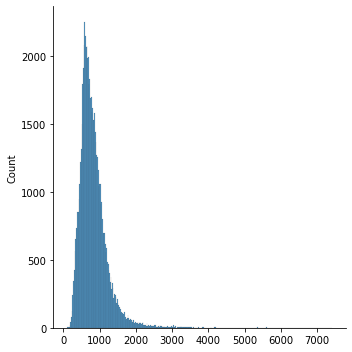

152.65341080466897
Fold 0 end
Fold 1 start
(276069, 249)
y dist plot


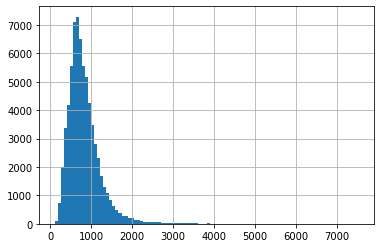

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2406
[LightGBM] [Info] Number of data points in the train set: 276069, number of used features: 212
[LightGBM] [Info] Start training from score 827.987016
Training until validation scores don't improve for 100 rounds

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.



[50]	valid_0's rmse: 212.091
[100]	valid_0's rmse: 200.156
[150]	valid_0's rmse: 194.118
[200]	valid_0's rmse: 189.867
[250]	valid_0's rmse: 186.564
[300]	valid_0's rmse: 184.347
[350]	valid_0's rmse: 182.276
[400]	valid_0's rmse: 180.432
[450]	valid_0's rmse: 178.868
[500]	valid_0's rmse: 177.585
[550]	valid_0's rmse: 176.411
[600]	valid_0's rmse: 175.374
[650]	valid_0's rmse: 174.314
[700]	valid_0's rmse: 173.373
[750]	valid_0's rmse: 172.445
[800]	valid_0's rmse: 171.707
[850]	valid_0's rmse: 171.072
[900]	valid_0's rmse: 170.324
[950]	valid_0's rmse: 169.647
[1000]	valid_0's rmse: 169.057
[1050]	valid_0's rmse: 168.441
[1100]	valid_0's rmse: 167.934
[1150]	valid_0's rmse: 167.451
[1200]	valid_0's rmse: 166.939
[1250]	valid_0's rmse: 166.463
[1300]	valid_0's rmse: 165.975
[1350]	valid_0's rmse: 165.57
[1400]	valid_0's rmse: 165.176
[1450]	valid_0's rmse: 164.822
[1500]	valid_0's rmse: 164.451
[1550]	valid_0's rmse: 164.019
[1600]	valid_0's rmse: 163.634
[1650]	valid_0's rmse: 163.2

<Figure size 432x288 with 0 Axes>

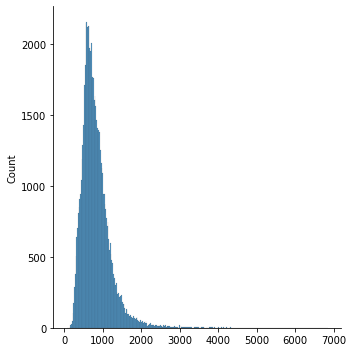

149.48985595721027
Fold 1 end
Fold 2 start
(276070, 249)
y dist plot


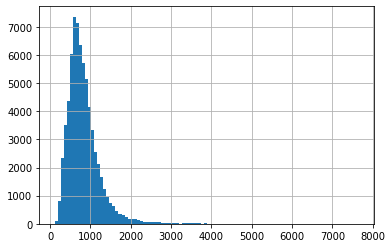

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 276070, number of used features: 212


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 828.082388
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 212.497
[100]	valid_0's rmse: 199.557
[150]	valid_0's rmse: 193.368
[200]	valid_0's rmse: 189.203
[250]	valid_0's rmse: 186.064
[300]	valid_0's rmse: 183.498
[350]	valid_0's rmse: 181.243
[400]	valid_0's rmse: 179.278
[450]	valid_0's rmse: 177.855
[500]	valid_0's rmse: 176.544
[550]	valid_0's rmse: 175.432
[600]	valid_0's rmse: 174.267
[650]	valid_0's rmse: 173.351
[700]	valid_0's rmse: 172.468
[750]	valid_0's rmse: 171.65
[800]	valid_0's rmse: 170.861
[850]	valid_0's rmse: 170.169
[900]	valid_0's rmse: 169.646
[950]	valid_0's rmse: 169.059
[1000]	valid_0's rmse: 168.463
[1050]	valid_0's rmse: 167.883
[1100]	valid_0's rmse: 167.341
[1150]	valid_0's rmse: 166.815
[1200]	valid_0's rmse: 166.356
[1250]	valid_0's rmse: 165.875
[1300]	valid_0's rmse: 165.467
[1350]	valid_0's rmse: 165.032
[1400]	valid_0's rmse: 164.663
[1450]	valid_0's rmse: 164.241
[1500

<Figure size 432x288 with 0 Axes>

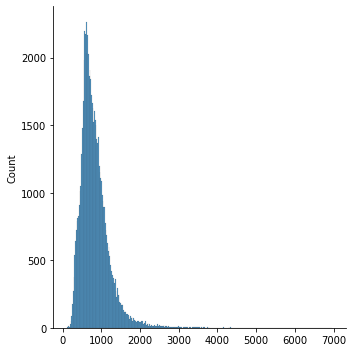

150.76606121397626
Fold 2 end
Fold 3 start
(276070, 249)
y dist plot


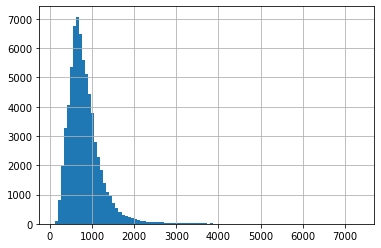

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2415
[LightGBM] [Info] Number of data points in the train set: 276070, number of used features: 215


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 827.831444
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 214.37
[100]	valid_0's rmse: 202.33
[150]	valid_0's rmse: 196.344
[200]	valid_0's rmse: 192.482
[250]	valid_0's rmse: 189.271
[300]	valid_0's rmse: 186.927
[350]	valid_0's rmse: 184.885
[400]	valid_0's rmse: 183.278
[450]	valid_0's rmse: 181.776
[500]	valid_0's rmse: 180.478
[550]	valid_0's rmse: 179.223
[600]	valid_0's rmse: 178.114
[650]	valid_0's rmse: 177.154
[700]	valid_0's rmse: 176.315
[750]	valid_0's rmse: 175.555
[800]	valid_0's rmse: 174.905
[850]	valid_0's rmse: 174.129
[900]	valid_0's rmse: 173.544
[950]	valid_0's rmse: 172.858
[1000]	valid_0's rmse: 172.199
[1050]	valid_0's rmse: 171.594
[1100]	valid_0's rmse: 171.092
[1150]	valid_0's rmse: 170.526
[1200]	valid_0's rmse: 170.017
[1250]	valid_0's rmse: 169.536
[1300]	valid_0's rmse: 169.168
[1350]	valid_0's rmse: 168.684
[1400]	valid_0's rmse: 168.301
[1450]	valid_0's rmse: 167.945
[1500]

<Figure size 432x288 with 0 Axes>

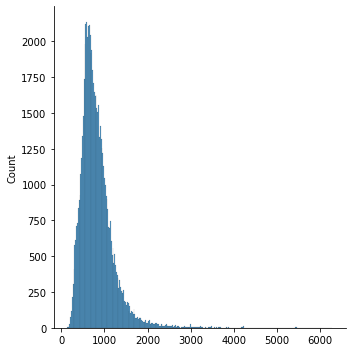

154.45429783396773
Fold 3 end
Fold 4 start
(276070, 249)
y dist plot


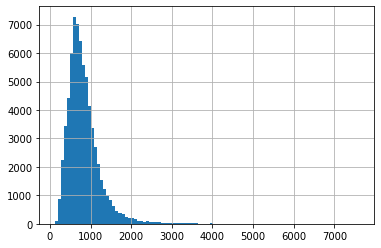

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 276070, number of used features: 216


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 827.055224
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 213.11
[100]	valid_0's rmse: 200.646
[150]	valid_0's rmse: 193.947
[200]	valid_0's rmse: 189.472
[250]	valid_0's rmse: 186.208
[300]	valid_0's rmse: 183.642
[350]	valid_0's rmse: 181.473
[400]	valid_0's rmse: 179.67
[450]	valid_0's rmse: 178.108
[500]	valid_0's rmse: 176.844
[550]	valid_0's rmse: 175.657
[600]	valid_0's rmse: 174.449
[650]	valid_0's rmse: 173.417
[700]	valid_0's rmse: 172.593
[750]	valid_0's rmse: 171.662
[800]	valid_0's rmse: 170.853
[850]	valid_0's rmse: 170.1
[900]	valid_0's rmse: 169.47
[950]	valid_0's rmse: 168.808
[1000]	valid_0's rmse: 168.387
[1050]	valid_0's rmse: 167.658
[1100]	valid_0's rmse: 167.147
[1150]	valid_0's rmse: 166.642
[1200]	valid_0's rmse: 166.206
[1250]	valid_0's rmse: 165.84
[1300]	valid_0's rmse: 165.448
[1350]	valid_0's rmse: 165.052
[1400]	valid_0's rmse: 164.65
[1450]	valid_0's rmse: 164.288
[1500]	vali

<Figure size 432x288 with 0 Axes>

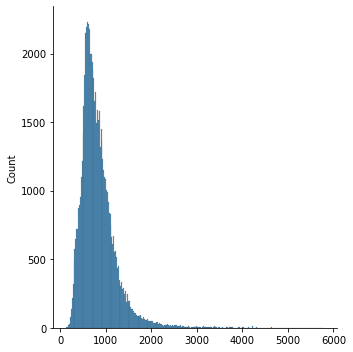

151.97824345718342
Fold 4 end


<Figure size 432x288 with 0 Axes>

In [22]:
count = 0
oof = np.zeros(training_data_df.shape[0])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격대지권면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격대지권면적']
    
    print('y dist plot')
    y_val.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'regression',
        #'alpha': 1.35,
        'learning_rate': 0.1,
        'seed': 42,
        #'max_depth': 12,
        #'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'rmse',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 50000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=100, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_mse_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.displot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    print(np.sqrt(mean_squared_error(y_val, preds)))
    
    print('Fold {} end'.format(count))
    count += 1
    

In [24]:
np.sqrt(mean_squared_error(training_data_df['가격대지권면적'], oof))

151.87771112185223

In [ ]:
count = 0
oof = np.zeros(training_data_df.shape[0])

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['target_area_log']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['target_area_log']
    
    print('y dist plot')
    y_val.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'regression',
        'learning_rate': 0.3,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'rmse',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 50000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=100, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_mse_shap_top_22_lr_3_target_log_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    print(np.sqrt(mean_squared_error(y_val, preds)))
    
    print('Fold {} end'.format(count))
    count += 1
    

In [ ]:
np.sqrt(mean_squared_error(training_data_df['target_area_log'], oof))